In [1]:
import jax
import jax.numpy as jnp
from ml_collections import config_flags
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optax

In [10]:
from galaxy_diffusion.rand_manifolds import random_manifolds
from galaxy_diffusion import plotting_utils
from galaxy_diffusion import linalg
from galaxy_diffusion import utils

import config_base

In [3]:
def get_dataset(rng, config):
    """Return the dataset specified in the config. Same function as in train.py"""

    # Rng per source.
    rng_x, rng_a, rng_y = jax.random.split(rng, 3)

    # Generate our sources.
    x_all = []
    # Split within loop to ensure that the sources generated are consistent
    # across different numbers for config.n_sources.
    if isinstance(config.alpha, list):
        assert len(config.alpha) == config.n_sources
        alpha = config.alpha
    else:
        alpha = [config.alpha for i in range(config.n_sources)]
        
    if isinstance(config.phase, list):
        assert len(config.phase) == config.n_sources
        phase = config.phase
    else:
        phase = [config.phase for i in range(config.n_sources)]
        
    for _ in range(config.n_sources):
        rng_x, rng = jax.random.split(rng_x, 2)
        x_all.append(
            random_manifolds.generate_x(
                rng_x, config.sample_size, man_dim=1,
                feat_dim=config.feat_dim, alpha=alpha[_], phase=phase[_], normalize=True
            )
        )
    x_all = jnp.stack(x_all, axis=1)

    # Generate our A matrices, assuming the source matrix does not vary.
    A_all = random_manifolds.generate_A(
        rng_a, config.sample_size, obs_dim=config.obs_dim,
        feat_dim=config.feat_dim
    )[:, None]
    A_all = jnp.tile(A_all, (1, config.n_sources, 1, 1))

    # Generate our observations
    y_all, cov_y_all = [], []
    for n in range(config.n_sources):
        y, cov_y = random_manifolds.generate_y(
            rng_y, A_all[:, :(n+1)], x_all[:, :(n+1)], noise=config.sigma_y
        )

        # Put the covariance in the DPLR representation.
        cov_y = linalg.DPLR(diagonal=jnp.tile(cov_y[None], (y.shape[0], 1)))

        y_all.append(y)
        cov_y_all.append(cov_y)

    y_all = jnp.stack(y_all, axis=1)
    # Can't stack cov_y all since it's a DPLR matrix.

    return x_all, A_all, y_all, cov_y_all


In [4]:
def f(params, X_obs, Y_obs, L, M, gamma, dim):
    
    W, sigma2 = params

    mat_prod = jnp.matmul(W, W.T) + sigma2*jnp.eye(dim)
    
    A = L @ mat_prod @ jnp.matrix_transpose(L)
    B = M @ mat_prod @ jnp.matrix_transpose(M)


    # Matrix loss
    loss_x = jnp.mean(jnp.log(jnp.linalg.det(A)))
    loss_x += jnp.mean(
        jnp.trace(
            jnp.matmul(
                jnp.linalg.inv(A), 
                jnp.matmul(X_obs[..., None], jnp.matrix_transpose(X_obs[..., None]))
            ),
            axis1=-1, axis2=-2
        )
    )
    
    loss_y = 0
    if gamma != 0:
        loss_y += jnp.mean(jnp.log(jnp.linalg.det(B)))
        loss_y += jnp.mean(
            jnp.trace(
                jnp.matmul(
                    jnp.linalg.inv(B), 
                    jnp.matmul(Y_obs[..., None], jnp.matrix_transpose(Y_obs[..., None]))
                ),
                axis1=1, axis2=2
            )
        )
        loss_y *= gamma
    
    loss = loss_x - loss_y
    
    return loss

f_jit = jax.jit(f, static_argnames=['dim'])

In [5]:
config = config_base.get_config()
rng = jax.random.PRNGKey(config.rng_key)

# Generate our dataset.
rng, rng_data = jax.random.split(rng)
x_all, A_all, y_all, cov_y_all = get_dataset(rng_data, config)

latent_dim = 2
feat_dim = config.feat_dim
obs_dim = config.obs_dim
dataset_size = config.sample_size

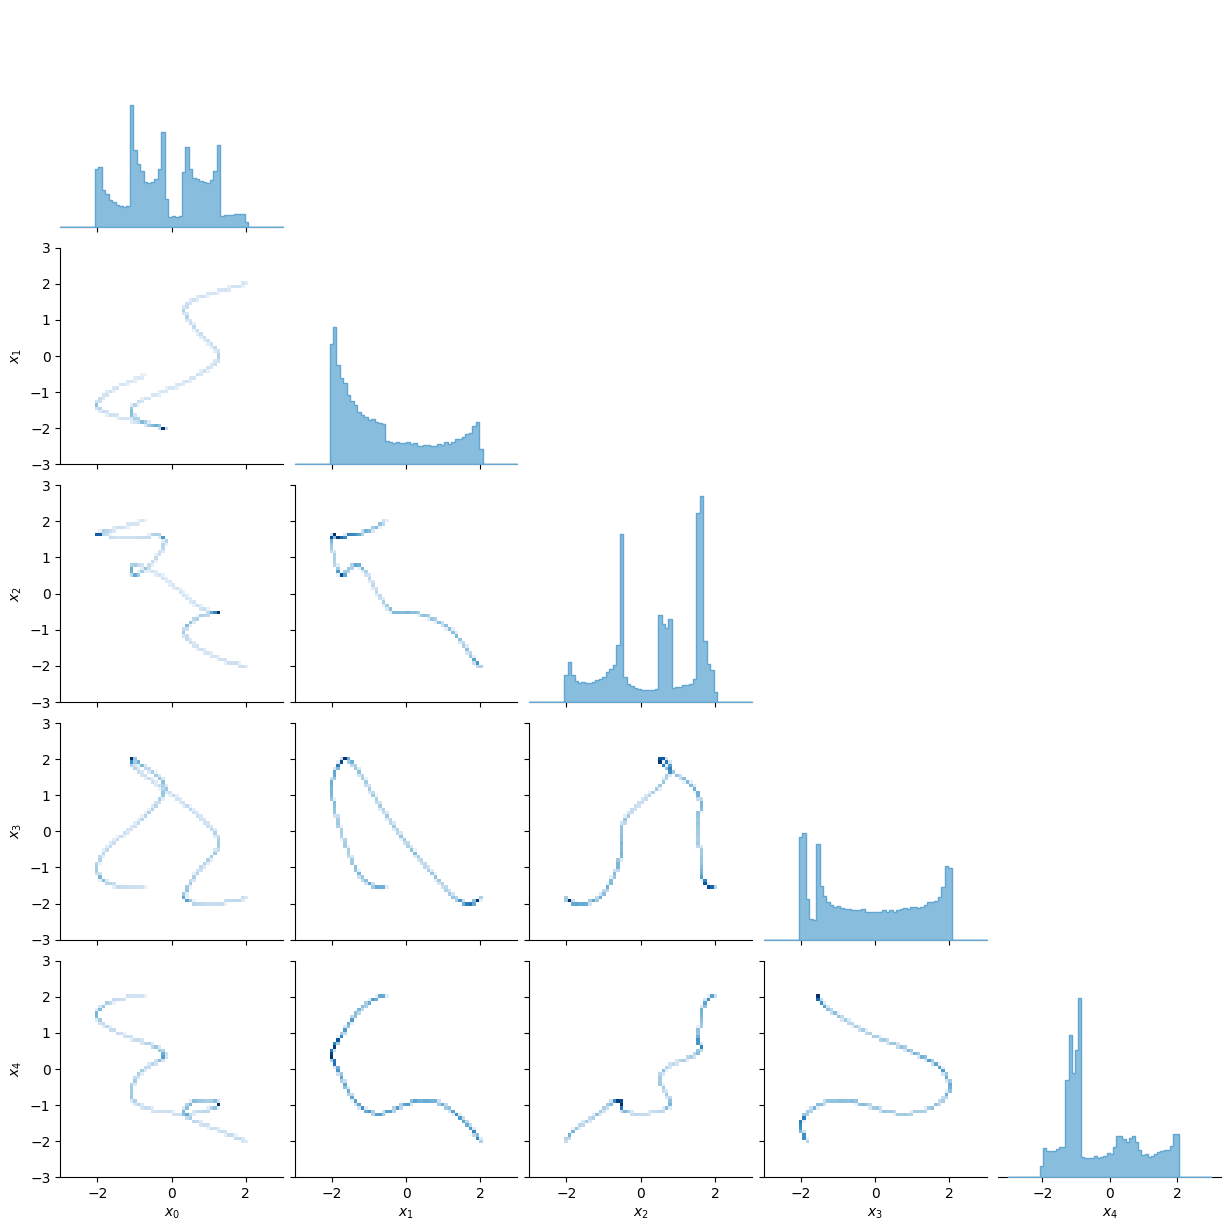

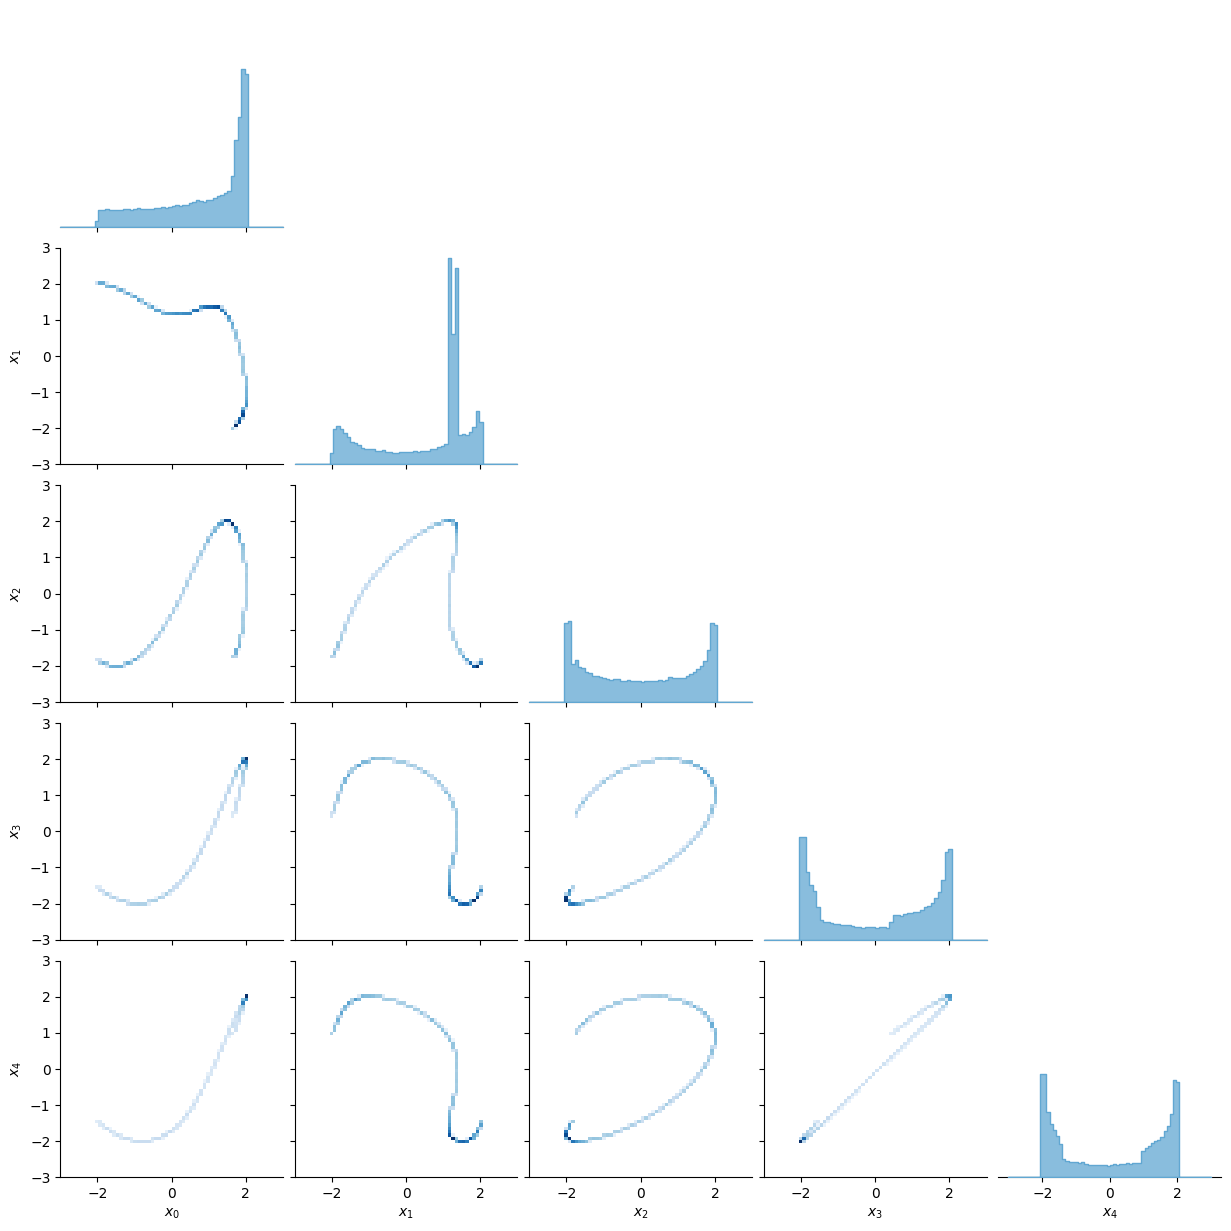

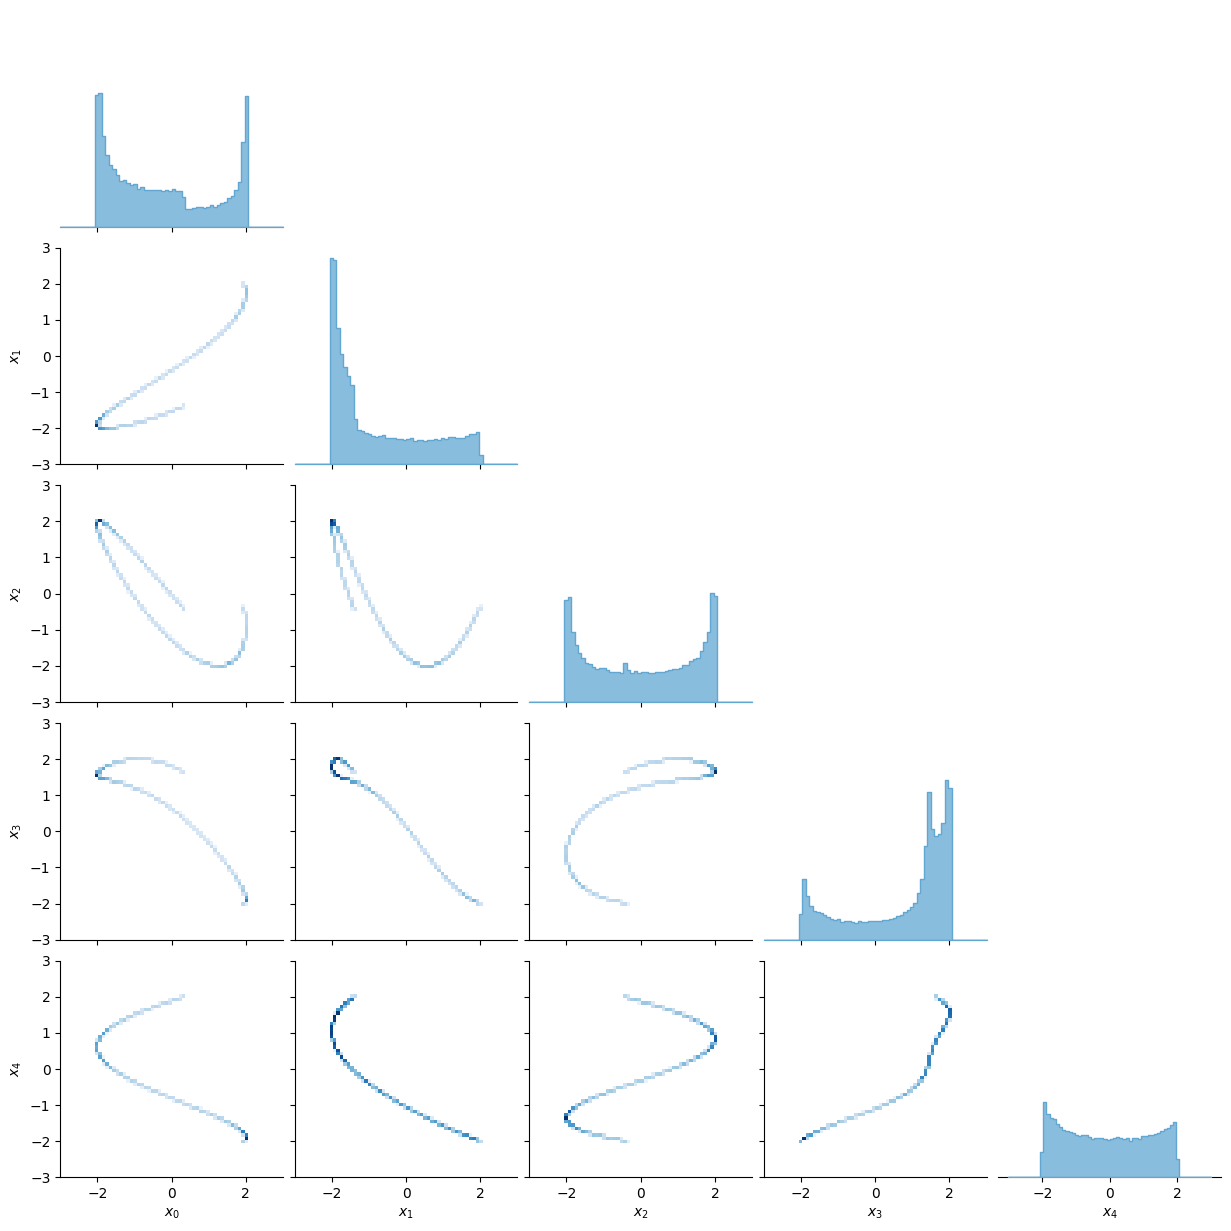

In [6]:
# Plot true distribution.
plotting_utils.show_corner(x_all[:,0])
plt.show()

plotting_utils.show_corner(x_all[:,1])
plt.show()

plotting_utils.show_corner(x_all[:,2])
plt.show()

## PCPCA for $x^1$

In [24]:
# Reformulate the problem in the terms used in PCPCA.
gamma = 0.
x_obs = y_all[:,0]
y_obs = jnp.zeros_like(y_all[:,0])

L = A_all[:, 0]
M = jnp.ones_like(A_all[:, 0])


# Initialize W and sigma2.
rng, _ = jax.random.split(rng, 2)
W_init = (jax.random.uniform(rng, shape=(feat_dim, latent_dim)) - 0.5)
sigma2_init = 0.3
params = (jnp.asarray(W_init), jnp.asarray(sigma2_init))

# Optimization loop parameters.
n_iter = 4_000
learning_rate = 1e-2
schedule = optax.schedules.cosine_decay_schedule(init_value=learning_rate, decay_steps=n_iter)
solver = optax.inject_hyperparams(optax.sgd, static_args=['learning_rate'])(learning_rate=schedule)

print('Objective function: ', f(params, x_obs, y_obs, L, M, gamma, feat_dim))
opt_state = solver.init(params)

# Run the optimization loop.
for _ in range(n_iter):
    grad = jax.grad(f, argnums=0, allow_int=True)(params, x_obs, y_obs, L, M, gamma, feat_dim)
    updates, opt_state = solver.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    if (_ + 1) % 100 == 0:
        print('Iter: {:d}, Objective function: {:.4}'.format(_ + 1, f(params, x_obs, y_obs, L, M, gamma, feat_dim)))

Objective function:  5.9291024
Iter: 100, Objective function: 2.224
Iter: 200, Objective function: 1.578
Iter: 300, Objective function: 1.513
Iter: 400, Objective function: 1.506
Iter: 500, Objective function: 1.505
Iter: 600, Objective function: 1.504
Iter: 700, Objective function: 1.504
Iter: 800, Objective function: 1.504
Iter: 900, Objective function: 1.504
Iter: 1000, Objective function: 1.504
Iter: 1100, Objective function: 1.504
Iter: 1200, Objective function: 1.504
Iter: 1300, Objective function: 1.504
Iter: 1400, Objective function: 1.504
Iter: 1500, Objective function: 1.504
Iter: 1600, Objective function: 1.504
Iter: 1700, Objective function: 1.504
Iter: 1800, Objective function: 1.504
Iter: 1900, Objective function: 1.504
Iter: 2000, Objective function: 1.504
Iter: 2100, Objective function: 1.504
Iter: 2200, Objective function: 1.504
Iter: 2300, Objective function: 1.504
Iter: 2400, Objective function: 1.504
Iter: 2500, Objective function: 1.504
Iter: 2600, Objective functi

Sinkhorn divergence for x1:10.447


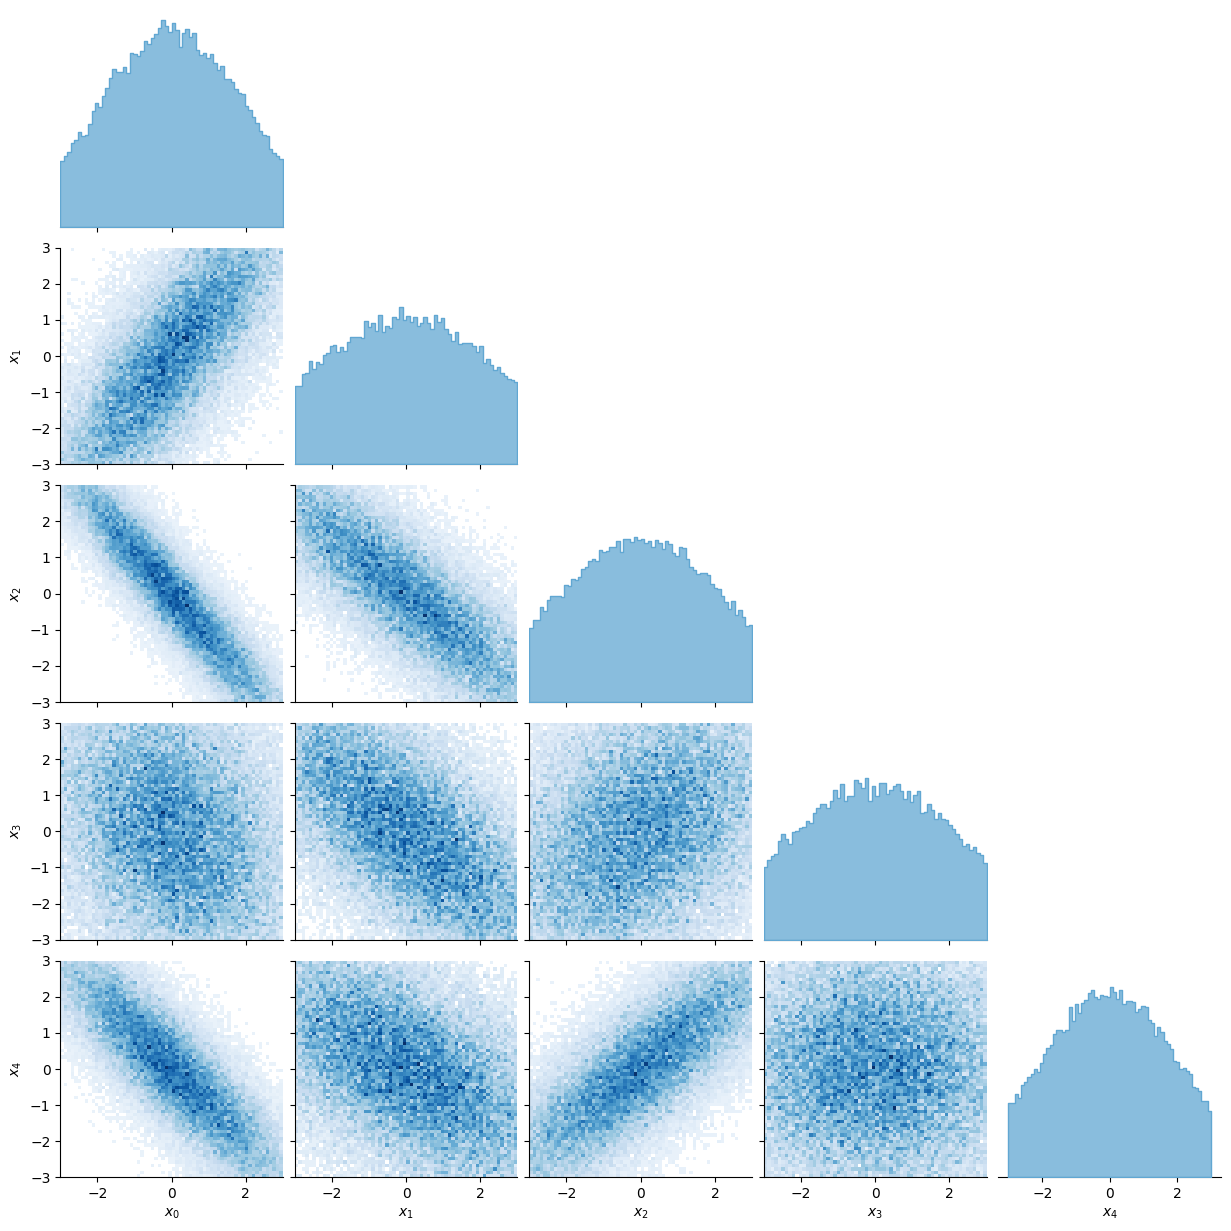

In [28]:
# Compute predicted posterior samples.
rng_x, rng_eps_x, rng = jax.random.split(rng, 3)
z_x   = jax.random.normal(rng_x, shape=(dataset_size, latent_dim))
x1_pred = jnp.matmul(params[0], z_x.T).T
x1_pred = x1_pred  + jax.random.multivariate_normal(rng_eps_x, 
                                                  mean=x1_pred, 
                                                  cov=jnp.eye(feat_dim)*params[1])


divergence_x1 = utils.sinkhorn_divergence(x1_pred[:config.sinkhorn_samples], x_all[:config.sinkhorn_samples, 0])
print(fr'Sinkhorn divergence for x1:{divergence_x1:.3f}')

plotting_utils.show_corner(x1_pred)
plt.show()


## PCPCA for $x^2$

In [15]:
# Reformulate the problem for PCPCA.
gamma = 0.3
x_obs = y_all[:,1]
y_obs = y_all[:,0]

L = A_all[:, 1]
M = A_all[:, 0]

# Initialize W and sigma2.
rng, _ = jax.random.split(rng, 2)
W_init = (jax.random.uniform(rng, shape=(feat_dim, latent_dim)) - 0.5)
sigma2_init = 0.3
params = (jnp.asarray(W_init), jnp.asarray(sigma2_init))

# Optimization loop parameters.
n_iter = 10_000
learning_rate = 1e-2
schedule = optax.schedules.cosine_decay_schedule(init_value=learning_rate, decay_steps=n_iter)
solver = optax.inject_hyperparams(optax.sgd, static_args=['learning_rate'])(learning_rate=schedule)

print('Objective function: ', f(params, x_obs, y_obs, L, M, gamma, feat_dim))
opt_state = solver.init(params)

# Run the optimization loop.
for _ in range(n_iter):
    grad = jax.grad(f, argnums=0, allow_int=True)(params, x_obs, y_obs, L, M, gamma, feat_dim)
    updates, opt_state = solver.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    if (_ + 1) % 100 == 0:
        print('Iter: {:d}, Objective function: {:.4}'.format(_ + 1, f(params, x_obs, y_obs, L, M, gamma, feat_dim)))

Objective function:  20.258358
Iter: 100, Objective function: 4.585
Iter: 200, Objective function: 4.274
Iter: 300, Objective function: 4.142
Iter: 400, Objective function: 4.071
Iter: 500, Objective function: 4.027
Iter: 600, Objective function: 3.997
Iter: 700, Objective function: 3.976
Iter: 800, Objective function: 3.96
Iter: 900, Objective function: 3.948
Iter: 1000, Objective function: 3.939
Iter: 1100, Objective function: 3.932
Iter: 1200, Objective function: 3.926
Iter: 1300, Objective function: 3.921
Iter: 1400, Objective function: 3.916
Iter: 1500, Objective function: 3.912
Iter: 1600, Objective function: 3.909
Iter: 1700, Objective function: 3.905
Iter: 1800, Objective function: 3.902
Iter: 1900, Objective function: 3.899
Iter: 2000, Objective function: 3.897
Iter: 2100, Objective function: 3.894
Iter: 2200, Objective function: 3.892
Iter: 2300, Objective function: 3.89
Iter: 2400, Objective function: 3.889
Iter: 2500, Objective function: 3.887
Iter: 2600, Objective function

31.801924


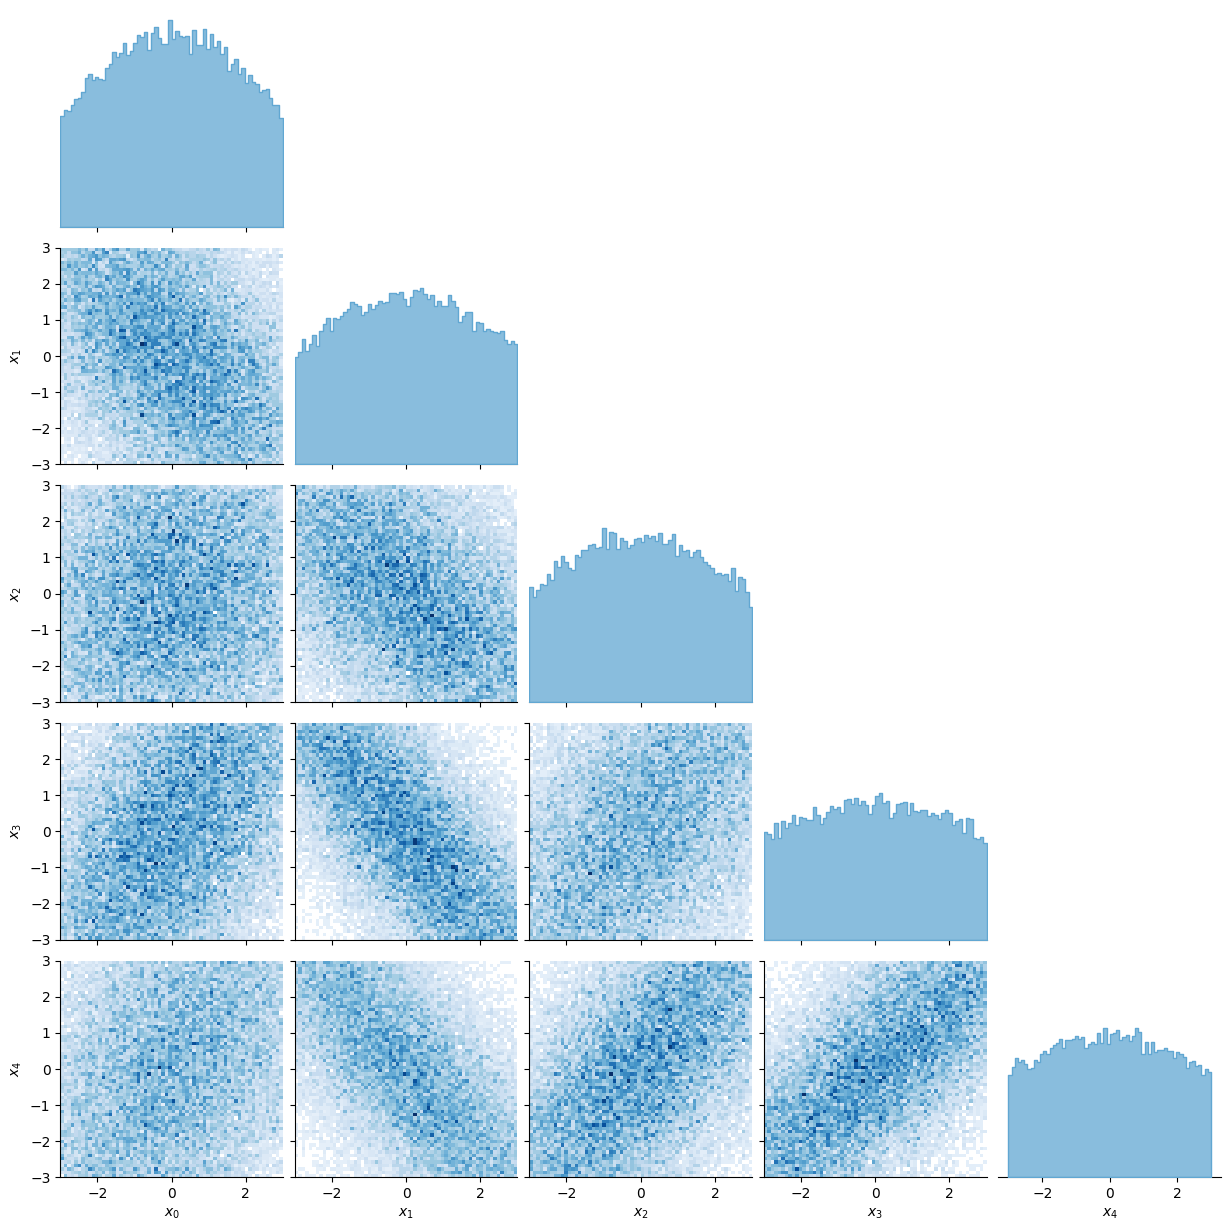

In [16]:
# Compute predicted posterior samples.
rng_x, rng_eps_x, rng = jax.random.split(rng, 3)
z_x   = jax.random.normal(rng_x, shape=(dataset_size, latent_dim))
x2_pred = jnp.matmul(params[0], z_x.T).T
x2_pred = x2_pred  + jax.random.multivariate_normal(rng_eps_x, 
                                       mean=x2_pred, 
                                       cov=jnp.eye(feat_dim)*params[1])


divergence_x2 = utils.sinkhorn_divergence(x2_pred[:config.sinkhorn_samples], x_all[:config.sinkhorn_samples, 1])
print(divergence_x2)

plotting_utils.show_corner(x2_pred)
plt.show()


## PCPCA for $x^3$

In [17]:
# Reformulate the problem in the terms used in PCPCA.
gamma = 0.3
x_obs = y_all[:,2]
y_obs = y_all[:,1]

L = A_all[:, 2]
M = A_all[:, 1]

# Initialize W and sigma2.
rng, _ = jax.random.split(rng, 2)
W_init = (jax.random.uniform(rng, shape=(feat_dim, latent_dim)) - 0.5)
sigma2_init = 0.3
params = (jnp.asarray(W_init), jnp.asarray(sigma2_init))

# Run the optimization loop.
n_iter = 10_000
learning_rate = 1e-2
schedule = optax.schedules.cosine_decay_schedule(init_value=learning_rate, decay_steps=n_iter)
solver = optax.inject_hyperparams(optax.sgd, static_args=['learning_rate'])(learning_rate=schedule)

print('Objective function: ', f(params, x_obs, y_obs, L, M, gamma, feat_dim))
opt_state = solver.init(params)

for _ in range(n_iter):
    grad = jax.grad(f, argnums=0, allow_int=True)(params, x_obs, y_obs, L, M, gamma, feat_dim)
    updates, opt_state = solver.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    if (_ + 1) % 100 == 0:
        print('Iter: {:d}, Objective function: {:.4}'.format(_ + 1, f(params, x_obs, y_obs, L, M, gamma, feat_dim)))

Objective function:  27.984085
Iter: 100, Objective function: 5.205
Iter: 200, Objective function: 4.846
Iter: 300, Objective function: 4.715
Iter: 400, Objective function: 4.65
Iter: 500, Objective function: 4.611
Iter: 600, Objective function: 4.585
Iter: 700, Objective function: 4.566
Iter: 800, Objective function: 4.552
Iter: 900, Objective function: 4.54
Iter: 1000, Objective function: 4.531
Iter: 1100, Objective function: 4.523
Iter: 1200, Objective function: 4.517
Iter: 1300, Objective function: 4.511
Iter: 1400, Objective function: 4.507
Iter: 1500, Objective function: 4.503
Iter: 1600, Objective function: 4.5
Iter: 1700, Objective function: 4.497
Iter: 1800, Objective function: 4.495
Iter: 1900, Objective function: 4.493
Iter: 2000, Objective function: 4.491
Iter: 2100, Objective function: 4.49
Iter: 2200, Objective function: 4.489
Iter: 2300, Objective function: 4.488
Iter: 2400, Objective function: 4.488
Iter: 2500, Objective function: 4.487
Iter: 2600, Objective function: 4

56.889603


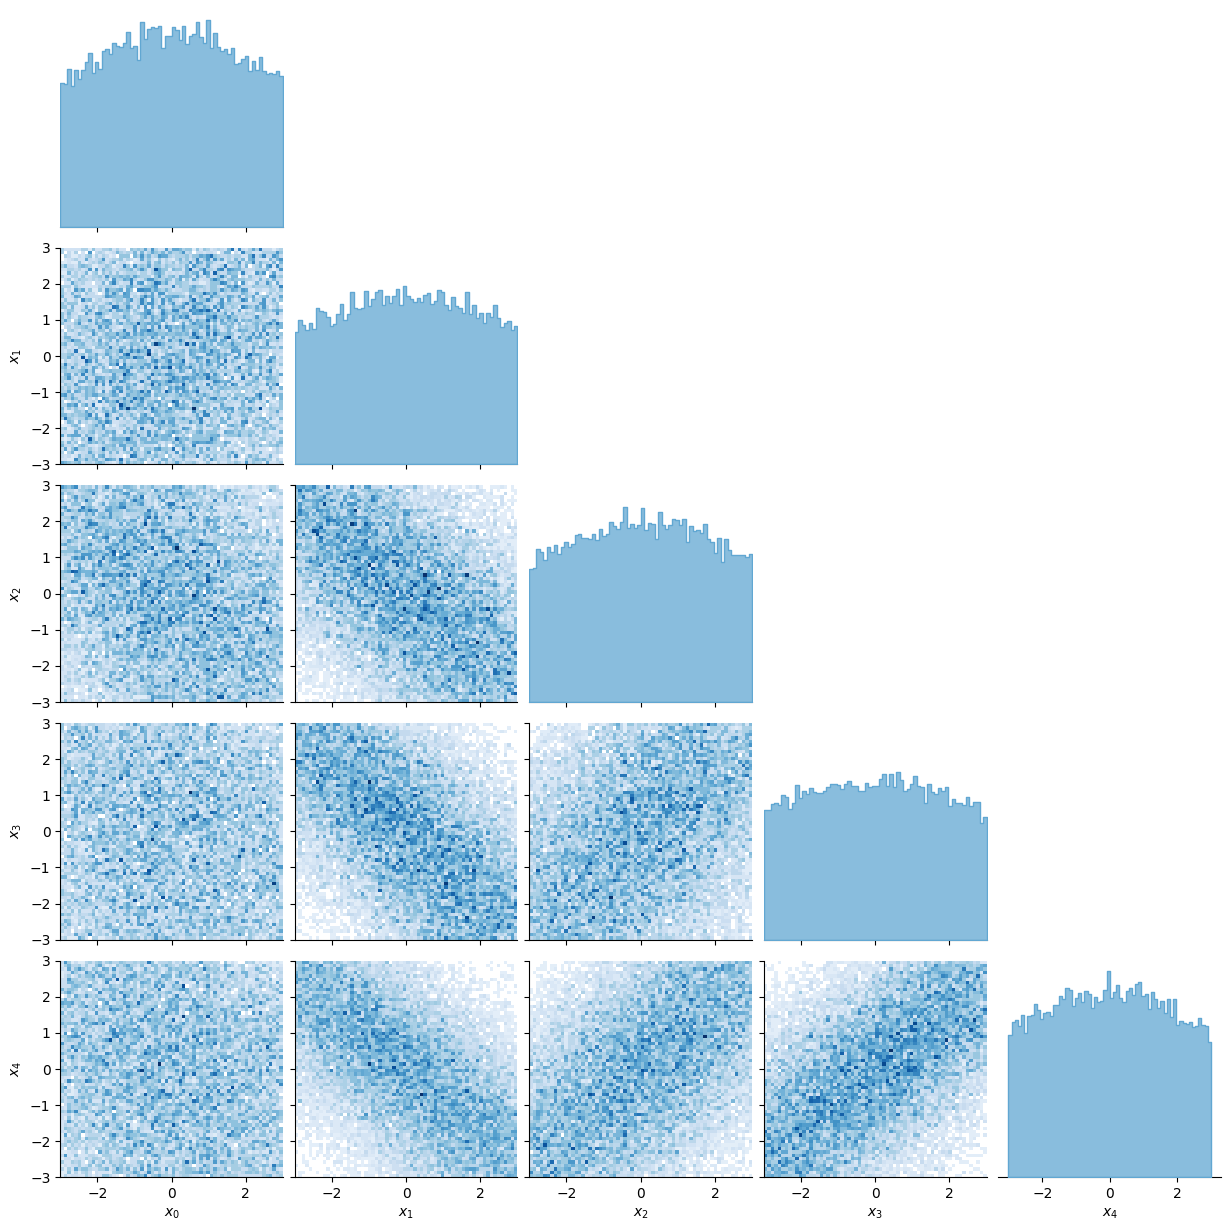

In [18]:
# Compute predicted posterior samples.
rng_x, rng_eps_x, rng = jax.random.split(rng, 3)
z_x   = jax.random.normal(rng_x, shape=(dataset_size, latent_dim))
x3_pred = jnp.matmul(params[0], z_x.T).T
x3_pred = x3_pred  + jax.random.multivariate_normal(rng_eps_x, 
                                       mean=x3_pred, 
                                       cov=jnp.eye(feat_dim)*params[1])


divergence_x3 = utils.sinkhorn_divergence(x3_pred[:config.sinkhorn_samples],
                                       x_all[:config.sinkhorn_samples, 2])
print(divergence_x3)

plotting_utils.show_corner(x3_pred)
plt.show()